In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from matplotlib.pylab import rcParams
from sklearn import neighbors
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold

%matplotlib inline

# Useful functions

In [2]:
#convert shot flags to colors
def flag_colors(flag):
    if flag == 1: return 'green'
    if flag == 0: return 'red'
    return 'black'

In [3]:
# convert matchup string to Home=1, away=0
# example: LAL @ POR: home=0
# example: LAL vs. POR: home=1
def get_home_away(string):
    if '@' in string: return 0 #away
    elif 'vs' in string : return 1 #home
    else: return "ACORDA CRL"

In [4]:
# convert season in format '1999-00' to 
# example: '1999-00': 3
def get_season_num(year):
    # year is in format '2009-10'
    year0 = 1996
    y = year[:4]
    y_int = int(y)
    
    return y_int - year0

#quick asserts
assert get_season_num('2010-11') == 14
assert get_home_away('LAL @ POR') == 0
assert get_home_away('LAL vs UTA') == 1    

# Import data

In [5]:
data = pd.read_csv('data.csv')
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [6]:
list(data.columns.values)

['action_type',
 'combined_shot_type',
 'game_event_id',
 'game_id',
 'lat',
 'loc_x',
 'loc_y',
 'lon',
 'minutes_remaining',
 'period',
 'playoffs',
 'season',
 'seconds_remaining',
 'shot_distance',
 'shot_made_flag',
 'shot_type',
 'shot_zone_area',
 'shot_zone_basic',
 'shot_zone_range',
 'team_id',
 'team_name',
 'game_date',
 'matchup',
 'opponent',
 'shot_id']

# Notes

* Can we improve the missing data strategy?
* Are all the limitations to algorithm application verified?

* prevent leakage: train only on shots prior to the ones we're predicting (year)
* select features and then explore number of neighbours

* target: score=0.75

# Preprocessing

In [7]:
# TRAINING AND TEST DATA
train_data, test_data = train_test_split(data, test_size = 0.2, random_state = 0)

In [8]:
# MISSING DATA
# don't consider rows with shot_made_flag = NaN
train_data = train_data[np.isfinite(train_data['shot_made_flag'])]
test_data = test_data[np.isfinite(test_data['shot_made_flag'])]

   # Exploring features

### Correlation matrix

In [ ]:
cm = data.corr()
cm.loc['shot_made_flag']

#### Comments:

* Needs normalization

### Opponent

In [ ]:
total_shots = pd.pivot_table(data, index="opponent", values="shot_id", aggfunc='count')
shots_scored = pd.pivot_table(data, index="opponent", values="shot_made_flag", aggfunc='sum')

accuracy = shots_scored/total_shots

In [ ]:
accuracy.plot.bar(title='Kobe Bryant\n% by opponent')

#### Comments:

* xxx

### Shots by distance

In [ ]:
total_distance = pd.pivot_table(data, index="shot_distance", values="shot_id", aggfunc='count')
shots_scored = pd.pivot_table(data, index="shot_distance", values="shot_made_flag", aggfunc='sum')

accuracy = shots_scored/total_distance

In [ ]:
accuracy.plot.bar(title='Kobe Bryant\n% by distance')
plt.axis([0, 30, 0, .6])

#### Comments:

* Strange values when shot_distance = 0

### Minutes remaining

In [ ]:
minutes = pd.pivot_table(data, index="minutes_remaining", values="shot_id", aggfunc='count')
shots_scored = pd.pivot_table(data, index="minutes_remaining", values="shot_made_flag", aggfunc='sum')

accuracy = shots_scored/minutes

In [ ]:
accuracy.plot.bar(title='Kobe Bryant\n% by minutes remaining')
plt.axis([0, 11, 0, .5])

#### Comments:

* Accuracy decreases in minutes_remaining = 0

### Seconds remaining + Period

In [ ]:
seconds = pd.pivot_table(data, index=[ "seconds_remaining", 'period'], values="shot_id", aggfunc='count')
shots_scored = pd.pivot_table(data, index=[ "seconds_remaining", 'period'], values="shot_made_flag", aggfunc='sum')

accuracy = shots_scored/seconds

In [ ]:
accuracy

#### Comments:

* xxx

### Shots by zone range

In [ ]:
shot_zones = pd.pivot_table(data, index="shot_zone_range", values="shot_id", aggfunc='count')
shot_zones_pct = shot_zones/shot_zones.sum()

# change order
shot_zones_pct = shot_zones_pct.reindex(index=['Less Than 8 ft.',  u'8-16 ft.', u'16-24 ft.', u'24+ ft.', u'Back Court Shot'])
shot_zones_pct.plot.bar(title='Kobe Bryant\n% by zone range')

In [ ]:
# let's try plotting all of his shots and show if miss or hit

shots_pos = data[['loc_x', 'loc_y']]
shot_colors = map(flag_colors, data.shot_made_flag)
shots_pos.plot.scatter(x='loc_x', y='loc_y', s=5, c=shot_colors, ylim=(0,400), figsize=(10,5))

#### Comments:

* Heat map to understand accuracy

### Shots by action type

In [ ]:
shots_actionType = pd.pivot_table(data, index="action_type", values="shot_id", aggfunc='count')
shots_actionType.plot.bar(title='Kobe Bryant\naction type')

#### Comments:

* xxx

### Combined shot type

In [ ]:
shots_combined = pd.pivot_table(data, index="combined_shot_type", values="shot_id", aggfunc='count')
combined_scored = pd.pivot_table(data, index="combined_shot_type", values="shot_made_flag", aggfunc='sum')

accuracy = combined_scored / shots_combined

In [ ]:
accuracy.plot.bar(title='Kobe Bryant\n% combined shot type')

#### Comments:

* xxx

### Shots by period

In [ ]:
shots_period = pd.pivot_table(data, index="period", values="shot_id", aggfunc='count')
period_scored = pd.pivot_table(data, index="period", values="shot_made_flag", aggfunc='sum')

accuracy = period_scored/shots_period

In [ ]:
accuracy.plot.bar(title='Kobe Bryant\n% by period')

#### Comments:

* xxx

### Playoffs

In [ ]:
playoff_shots = pd.pivot_table(data, index="playoffs", values="shot_id", aggfunc='count')
playoff_scored = pd.pivot_table(data, index="playoffs", values="shot_made_flag", aggfunc='sum')

accuracy = playoff_scored/playoff_shots

In [ ]:
accuracy.plot.bar(title='Kobe Bryant\n% by playoff')

#### Comments:

* xxx

### Shot type

In [ ]:
shot_type = pd.pivot_table(data, index="shot_type", values="shot_id", aggfunc='count')
shotType_scored = pd.pivot_table(data, index="shot_type", values="shot_made_flag", aggfunc='sum')

accuracy = shotType_scored/shot_type

In [ ]:
accuracy.plot.bar(title='Kobe Bryant\n% by shot type')

#### Comments:

* xxx

### Season

In [ ]:
season = pd.pivot_table(data, index="season", values="shot_id", aggfunc='count')
season_scored = pd.pivot_table(data, index="season", values="shot_made_flag", aggfunc='sum')

season_accuracy = season_scored/season

In [ ]:
season_accuracy.plot.bar(title='Kobe Bryant\n% by shot type')

#### Comments: 

* xxx

## Missing Analysis

* Home/away
* Time of the year
* Location
* Day of the week

# 1. kNN

** References: **
* http://scikit-learn.org/stable/modules/neighbors.html
* http://www.amazon.com/Building-Machine-Learning-Systems-Python/dp/1784392774/ref=sr_1_1?ie=UTF8&qid=1461733493&sr=8-1&keywords=luis+pedro+coelho+python
* https://www.dataquest.io/blog/k-nearest-neighbors/
* http://stats.stackexchange.com/questions/136272/how-to-handle-data-normalization-in-knn-when-new-test-data-is-received

## New feature matrix

In [ ]:
# create design matrix
dm = data[['loc_x', 'loc_y', 'shot_distance', 'period', 'season', 'minutes_remaining', 'seconds_remaining', 'game_date', 
           'matchup', 'shot_made_flag']]

In [ ]:
# modify design matrix

# convert shot_distance from feet to meters
dm.loc[:,'shot_distance'] = dm['shot_distance'].apply(lambda x: x*0.3048)

# add angle feature and clean NaN by assuming angle=0 when distance=0
dm.loc[:,'angle'] = pd.Series(np.degrees(np.arctan(dm['loc_x']/dm['loc_y'])))
dm['angle'].fillna(0, inplace=True)

# convert matchup to Home/Away
# Home=0, Away=1
dm.loc[:, 'Home'] = dm['matchup'].apply(get_home_away)

# convert seasons to first, second etc
# needs: convert to date 
dm.loc[:,'season'] = dm['season'].apply(get_season_num)

# convert minutes + seconds remaining to time remaining in quarter (in seconds)
dm.loc[:, 'time_remaining'] = dm['minutes_remaining']*60 + dm['seconds_remaining']

# clean dataframe
cols_to_delete = ['loc_x', 'loc_y', 'minutes_remaining', 'seconds_remaining', 'matchup']
dm.drop(cols_to_delete, axis=1, inplace=True)

# temporary: also drop game_date
dm.drop('game_date', axis=1, inplace=True)

In [ ]:
# clean NaN in shot_made_flag column
dm.dropna(axis=0, how='any', inplace=True)

# make sure no NaNs in dm
assert dm.isnull().any().any()==False

## Cross-validation

In [ ]:
kf = KFold(len(dm), n_folds=5, shuffle=True)
l = [0]

for i in range(1,6):
    classifier = neighbors.KNeighborsClassifier(n_neighbors=i)

    # `means` will be a list of mean accuracies (one entry per fold)
    means = []

    X = dm.drop('shot_made_flag', axis=1).values
    Y = dm.shot_made_flag.values

    for training,testing in kf:
        # We fit a model for this fold, then apply it to the testing data with `predict`:
        classifier.fit(X[training], Y[training])
        prediction = classifier.predict(X[testing])

        # np.mean on an array of booleans returns fraction of correct decisions for this fold:
        curmean = np.mean(prediction == Y[testing])
        means.append(curmean)
    print("n_neighbors: {}".format(i))
    print("Mean accuracy: {:.1%}".format(np.mean(means)))
    l.append(np.mean(means))
plt.plot(l)
plt.axis([1, 5, .5, .57])

# Time series

** References: **
* http://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

### Time series matrix

In [9]:
ts = data
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
ts.game_date = map(dateparse, ts.game_date)

In [77]:
ts = data.set_index('game_date')

### Check stationarity

For practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

* constant mean
* constant variance
* an autocovariance that does not depend on time.

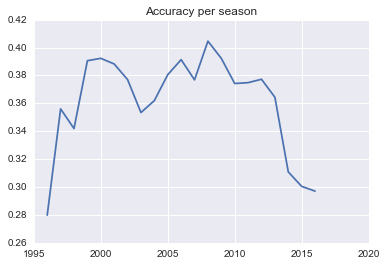

In [106]:
shots = pd.pivot_table(ts, index=ts.index, values="shot_id", aggfunc='count')
scored = pd.pivot_table(ts, index=ts.index, values="shot_made_flag", aggfunc='sum')
accuracy = scored/shots

x = ts.index.unique().sort_values()
y_year = accuracy.groupby(by=accuracy.index.year).mean()

plt.plot(y_year)
plt.title('Accuracy per season')

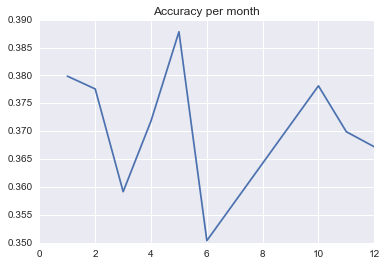

In [92]:
y_month = accuracy.groupby(by=accuracy.index.month).mean()
plt.plot(y_month)
plt.title('Accuracy per month')

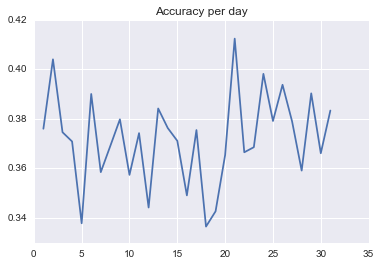

In [93]:
y_day = accuracy.groupby(by=accuracy.index.day).mean()
plt.plot(y_day)
plt.title('Accuracy per day')

In [114]:
#in construction
y = accuracy.groupby(by=[accuracy.index.year, accuracy.index.month]).mean()

In [113]:
ts.index.unique().sort_values()

DatetimeIndex(['1996-11-03', '1996-11-05', '1996-11-06', '1996-11-08',
               '1996-11-10', '1996-11-12', '1996-11-13', '1996-11-15',
               '1996-11-17', '1996-11-19',
               ...
               '2016-03-27', '2016-03-28', '2016-03-30', '2016-04-03',
               '2016-04-05', '2016-04-06', '2016-04-08', '2016-04-10',
               '2016-04-11', '2016-04-13'],
              dtype='datetime64[ns]', name=u'game_date', length=1559, freq=None)

In [115]:
y.index

MultiIndex(levels=[[1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016], [1, 2, 3, 4, 5, 6, 10, 11, 12]],
           labels=[[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20], [7, 8, 0, 1, 2, 3, 4, 6, 7, 8, 0, 1, 2, 3, 4, 1, 2, 3, 4, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 7, 8, 0, 1, 2, 3, 4, 5, 7, 8, 0, 1, 2, 3, 7, 8, 0, 1, 2, 3, 4, 7, 8, 0, 1, 2, 3, 4, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

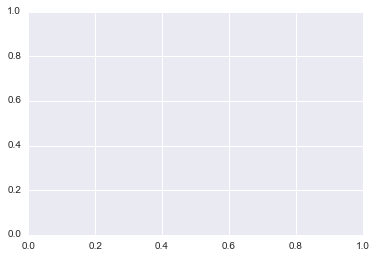

In [117]:
plt.plot(y.index, y)

** Dickey-Fuller test **
*  If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary
* Signed values should be compared and not the absolute values
* For example, if the test statistic is smaller than the 5% critical values, we can say with 95% confidence that this is a stationary series

In [85]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

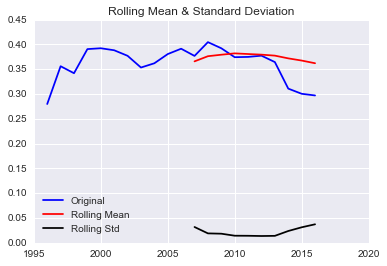

Results of Dickey-Fuller Test:
Test Statistic                 -0.000000
p-value                         0.958532
#Lags Used                      9.000000
Number of Observations Used    11.000000
Critical Value (5%)            -3.189369
Critical Value (1%)            -4.223238
Critical Value (10%)           -2.729839
dtype: float64


In [87]:
test_stationarity(y_year)

** Conclusion: **
* Non-stationary series

### Making time series stationary